# Pioneer Central Inshore Profiler (CP02PMCI) Data Quality Report
**Evaluation Date**: 5/23/2018

**Evaluator**: Bruce Laughlin

## Review Summary
This report summarizes a data quality review of the Pioneer Central Inshore Profiler (CP02PMCI).  We focus on data from the summer of 2017 (Deployment 8), and compare the profiler's CTD with a cruise CTD 

## 1. Selected instruments included in this report
In this report, we will evaluate the CTD (specifically temperature and salinity) from the Pioneer Central Inshore Profiler (CP02PMCI), focusing on the summer of 2017 (Deployment 8).

We focus on the telmetered data stream in this review because the recovered data are not yet available in the system for Deployment 8 (July 2017 and beyond). A graph of data availability is available at http://ooi.visualocean.net/instruments/stats-monthly/CP02PMCI-WFP01-03-CTDPFK000.

In [0]:
# Setup Instrument Variables
site = 'CP02PMCI'
node = 'WFP01'
instrument = '03-CTDPFK000'
method = 'telemetered'
stream = 'ctdpf_ckl_wfp_instrument'


## 2. Time periods of interest
We will focus on the following time periods for evaluation:


* June 16, 2017 to November 11, 2017 - All of Deployment 8
* One week around November 11, 2017 - The changeover from Deployment 8 to 9

## 3. Related Metadata
In this section, we will review some of metadata available in the system to make sure it is present and correct.

Before we get started, we need to set up our Python environment with some libraries, variables and functions we will need later in this report.

In [0]:
# Setup the Python processing environment 
import requests
import datetime
import pandas as pd
import time


In [0]:
# API Information
USERNAME ='OOIAPI-D7TI8MK8MAL1PZ'
TOKEN= 'J6UF0R8V58I215'
DATA_API = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
VOCAB_API = 'https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv'
ASSET_API = 'https://ooinet.oceanobservatories.org/api/m2m/12587'


In [0]:
# Specify some functions to convert timestamps
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)
  
def convert_time(ms):
  if ms != None:
    return datetime.datetime.utcfromtimestamp(ms/1000)
  else:
    return None


### 3a. Vocabulary Metadata
First, let's grab the basic vocabulary information (metadata) from the system to make sure we have the right instrument.

In [39]:
# Setup the API request url
data_request_url ='/'.join((VOCAB_API,site,node,instrument))
print data_request_url

# Grab the information from the server
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()
data

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/CP02PMCI/WFP01/03-CTDPFK000


[{u'@class': u'.VocabRecord',
  u'instrument': u'CTD',
  u'manufacturer': u'Sea-Bird',
  u'maxdepth': 104.0,
  u'mindepth': 15.0,
  u'model': u'SBE 52MP',
  u'refdes': u'CP02PMCI-WFP01-03-CTDPFK000',
  u'tocL1': u'Coastal Pioneer',
  u'tocL2': u'Central Inshore Profiler Mooring',
  u'tocL3': u'Wire-Following Profiler',
  u'vocabId': 495}]

All this looks good!

### 3b. Deployment Information
Next, let's grab some information about the deployments for this instrument.  We will grab all of the deployments available in the system for 2017 and then output the date ranges, latitude/longitude, asset ID, and sensor ID for each.  Note that the **reference designator** specified above represents the geographical location of an instrument across all deployments (e.g. the CTD on the Pioneer Central Inshore Profiler), the **Sensor ID** (and its Asset ID equivalent) represent the specific instrument used for a given deployment (i.e. a unique make, model, and serial numbered instrument).

In [6]:
# Setup the API request url
data_request_url = ASSET_API + '/events/deployment/query'
params = {
  'beginDT':'2017-01-01T00:00:00.000Z',
  'endDT':'2018-01-01T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+instrument,   
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
      'deployment': d['deploymentNumber'],
      'start': convert_time(d['eventStartTime']),
      'stop': convert_time(d['eventStopTime']),
      'latitude': d['location']['latitude'],
      'longitude': d['location']['longitude'],
      'sensor': d['sensor']['uid'],
      'asset_id': d['sensor']['assetId'],
    }, ignore_index=True)
df

,asset_id,deployment,latitude,longitude,sensor,start,stop
0,1625.0,7.0,40.22672,-70.878170,CGINS-CTDPFK-00113,2016-10-03 20:52:00,2017-06-17 12:12:00
1,1639.0,8.0,40.22695,-70.888933,CGINS-CTDPFK-00125,2017-06-16 19:55:00,2017-11-07 12:57:00
2,1623.0,9.0,40.22655,-70.878183,CGINS-CTDPFK-00111,2017-11-07 20:45:00,2018-04-11 13:46:00


### 3c. Calibration Information
When the system delivers data, it often uses a number of calibration coefficients to generated derived data products.

It turns out that this CTD instrument doesn't have any calibration information, because none is required by the system.

Instead, as an example of what the calibration information might look like (and to make sure something has been added to the system for this deployment), let's pull the calibration information for the neighboring FLORT for Deployment 8.  

Because the asset API can return confusing results, we will limit the search to just one day within the deployment time range.

In [7]:
# Setup the API request url
data_request_url = ASSET_API + '/asset/cal'
params = {
  'beginDT':'2017-07-01T00:00:00.000Z',
  'endDT':'2017-07-02T00:00:00.000Z',
  'refdes':site+'-'+node+'-'+'04-FLORTK000',
}

# Grab the information from the server
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()

# Reformat the data into a pretty table
df = pd.DataFrame() # Setup empty array
for d in data:
  for dd in d['sensor']['calibration']:
    for ddd in dd['calData']:
      df = df.append({
        'value': ddd['value'],
        'start': convert_time(ddd['eventStartTime']),
        'stop': convert_time(ddd['eventStopTime']),
        'name': ddd['eventName'],
        'assetUid': ddd['assetUid'],
        }, ignore_index=True)
    
df = df.sort_values(by=['start','name'])
df


,assetUid,name,start,stop,value
1,CGINS-FLORTK-01119,CC_angular_resolution,2016-12-12,None,1.076000
3,CGINS-FLORTK-01119,CC_dark_counts_cdom,2016-12-12,None,47.000000
4,CGINS-FLORTK-01119,CC_dark_counts_chlorophyll_a,2016-12-12,None,50.000000
8,CGINS-FLORTK-01119,CC_dark_counts_volume_scatter,2016-12-12,None,48.000000
7,CGINS-FLORTK-01119,CC_depolarization_ratio,2016-12-12,None,0.039000
2,CGINS-FLORTK-01119,CC_measurement_wavelength,2016-12-12,None,700.000000
9,CGINS-FLORTK-01119,CC_scale_factor_cdom,2016-12-12,None,0.066100
6,CGINS-FLORTK-01119,CC_scale_factor_chlorophyll_a,2016-12-12,None,0.011500
0,CGINS-FLORTK-01119,CC_scale_factor_volume_scatter,2016-12-12,None,0.000003
5,CGINS-FLORTK-01119,CC_scattering_angle,2016-12-12,None,124.000000


From the deployment table above, we can see that Deployment 8 began on 6/16/2017.  The system uses the calibration values that are closest in time but before the deployment start date. Note also, that calibrations do not have an end date.  It is assumed they are valid until the next calibration for the specific asset. 

So in this case, for Deployment 8, the calibration values from 12/12/2016 were used, which was when the instrument was last calibrated.


### 3d. Annotations
Finally, let's pull any relevant annotations for the CTD instrument.

In [42]:
ANNO_API = 'https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find'
params = {
  'beginDT':int(datetime.date(2017,1,1).strftime('%s'))*1000,
  'endDT':int(datetime.date(2018,1,1).strftime('%s'))*1000,
  'refdes':site+'-'+node+'-'+instrument,
}

r = requests.get(ANNO_API, params=params, auth=(USERNAME, TOKEN))
data = r.json()

df = pd.DataFrame() # Setup empty array
for d in data:
  df = df.append({
    'annotation': d['annotation'],
    'start': convert_time(d['beginDT']),
    'stop': convert_time(d['endDT']),
    'site': d['subsite'],
    'node': d['node'],
    'sensor': d['sensor'],
    'id': d['id']
  }, ignore_index=True)
pd.set_option('display.max_colwidth', -1) # Show the full annotation text
df

,annotation,id,node,sensor,site,start,stop
0,Data transmission interrupted.,605.0,WFP01,None,CP02PMCI,2017-02-07 12:00:00,2017-06-17 03:00:00


There's only one annotation currently in the system, and it's for the entire Wire Following Profiler. Apparently, transmission of telemetered data ceased approximately 4 months into deployment 7, and transmission did not begin again until the beginning of deployment 8.  Recovered data is available for this period.  There are currently no annotations for deployments 8 and 9; we will explore deplyoment 8 in order to confirm that everything is in order.

## 4. The full dataset
Now let's take a look at a large range of data.  We shall look at all of Deployment 8.  First we need to add some additional libraries to our Python environment.

In [9]:
import matplotlib.pyplot as plt

!pip install netCDF4
import netCDF4 as nc

!pip install xarray
import xarray as xr

!pip install cmocean
import cmocean

!pip install dask
!pip install bokeh

import re
import os


    100% |████████████████████████████████| 3.6MB 4.3MB/s 
    100% |████████████████████████████████| 3.3MB 5.3MB/s 
  Running setup.py bdist_wheel for cftime ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/10/32/0a/47d6323be1b72a6f4852f861f03ba69e826ba51aa6cfd2430b
Successfully built cftime
    100% |████████████████████████████████| 440kB 5.1MB/s 
    100% |████████████████████████████████| 266kB 5.3MB/s 
  Running setup.py bdist_wheel for cmocean ... - done
  Stored in directory: /content/.cache/pip/wheels/1e/9d/9e/0b3808afd7df52d465eca09f9175c185cfc0bb9fa43192e621
Successfully built cmocean


/usr/local/lib/python2.7/dist-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


    100% |████████████████████████████████| 2.3MB 4.7MB/s 
  Running setup.py bdist_wheel for dask ... - \ | done
  Stored in directory: /content/.cache/pip/wheels/8d/5d/b0/de56f34b25bc30bc140d5125429b73222ffb25c8260e8b141d
Successfully built dask
    100% |████████████████████████████████| 14.7MB 1.6MB/s 
  Running setup.py bdist_wheel for bokeh ... - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/ff/28/51/22e8d08e9d5383ee1de981aaa8ff7bc53c7d65022e5101400f
Successfully built bokeh


For simplicity, we used the Data Portal to make a download request for all available data.  After receiving the email, we looked through the results and here we specify just the netCDF file that includes the CTD data for all of deployment 8.  Using this data file, we will create a few different plots to better understand the available data.

In [0]:
# DATA REQUEST!
# Here try to look at entire year

beginDT = '2017-01-01T00:00:00.000Z',
endDT = '2018-01-01T00:00:00.000Z',

base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url ='/'.join((base_url,site,node,instrument,method,stream))
params = {
    'beginDT':beginDT,
    'endDT':endDT,   
}
r = requests.get(data_request_url, params=params, auth=(USERNAME,TOKEN))
data = r.json()

In [43]:
data['allURLs'][0]

TypeError: ignored

In [16]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed
CPU times: user 504 ms, sys: 39 ms, total: 543 ms
Wall time: 1min


Parse the thredds server to get a list of all NetCDF files. Each deployment is seperated into a seperate netcdf file

In [10]:
import requests

url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/catalog.html'
#url = data['allURLs'][0]
#url
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
datasets = requests.get(url).text
urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
x = re.findall(r'(ooi/.*?.nc)', datasets)
for i in x:
    if i.endswith('.nc') == False:
        x.remove(i)
for i in x:
    try:
        float(i[-4])
    except:
        x.remove(i)
datasets = [os.path.join(tds_url, i) for i in x]
datasets

[u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0009_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20171107T230003-20171231T223906.983240.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0008_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20170617T030003-20171026T134053.987597.nc',
 u'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0007_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20170101T000001-20170207T120924.985611.nc']

In [0]:
https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0009_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20171107T230003-20171231T223906.983240.nc

Load all files into a single xarray dataset.

In [11]:
# see notes on xarray - it is a really smart and powerful tool for dealing with data
# loads data to memory, not requiring download.  but actually loads the structure of the data
# rather than needing to load it all at once.  very smart, look up documentation (github, google)
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
#ds = ds.chunk({'time': 100}) # Sage - "Friedrich likes this 'ds.chunk' thing"
#ds = ds.sortby('time') # data from different deployments can overlap so we want to sort all data by time stamp.
ds
#ds['ctdmo_seawater_pressure'] #explore specific variable attributes
#ds['ctdmo_seawater_pressure'].comment #explore specific attribute of specific variable ( "comment" here )
# ['ctdmo_seawater_pressure']. then "tab" will give you all options (attributes AND functions)

<xarray.Dataset>
Dimensions:                                      (time: 1909619)
Coordinates:
    obs                                          (time) int64 0 1 2 3 4 5 6 ...
  * time                                         (time) datetime64[ns] 2017-11-07T23:00:03 ...
    pressure                                     (time) float64 3.539e+03 ...
    lat                                          (time) float64 40.23 40.23 ...
    lon                                          (time) float64 -70.88 ...
Data variables:
    deployment                                   (time) int32 9 9 9 9 9 9 9 ...
    id                                           (time) |S64 '587cfeee-7078-4653-ac94-302b7a7fd251' ...
    conductivity                                 (time) float64 4.779e+05 ...
    driver_timestamp                             (time) datetime64[ns] 2017-11-21T17:06:34.813453824 ...
    ingestion_timestamp                          (time) datetime64[ns] 2017-11-21T17:06:41.623000064 ...
    inter

In [30]:
# the following attempt to look at ALL of 2017 was too demanding on both my own computer's memory and what Google Collab allotted me, apparently

#data_url_7 = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0007_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20170101T000001-20170207T120924.985611.nc'
#data_url_8 = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0008_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20170617T030003-20171026T134053.987597.nc'
#data_url_9 = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T135952-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0009_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20171107T230003-20171231T223906.983240.nc'

# Open the dataset
#ds7 = xr.open_dataset(data_url_7)
#ds8 = xr.open_dataset(data_url_8)
#ds9 = xr.open_dataset(data_url_9)


# Swap the dimensions
#ds7 = ds7.swap_dims({'obs': 'time'})
#ds8 = ds8.swap_dims({'obs': 'time'})
#ds9 = ds9.swap_dims({'obs': 'time'})

#ds8


<xarray.Dataset>
Dimensions:                                      (time: 1141122)
Coordinates:
    obs                                          (time) int32 0 1 2 3 4 5 6 ...
  * time                                         (time) datetime64[ns] 2017-06-17T03:00:03 ...
    pressure                                     (time) float64 ...
    lat                                          (time) float64 ...
    lon                                          (time) float64 ...
Data variables:
    deployment                                   (time) int32 ...
    id                                           (time) |S64 ...
    conductivity                                 (time) float64 ...
    driver_timestamp                             (time) datetime64[ns] ...
    ingestion_timestamp                          (time) datetime64[ns] ...
    internal_timestamp                           (time) datetime64[ns] ...
    port_timestamp                               (time) datetime64[ns] ...
    preferr

In [12]:
data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T191503-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0008_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20170617T030003-20171026T134053.987597.nc'
# data_url = 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/blaughli@ucsc.edu/20180524T191503-CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument/deployment0009_CP02PMCI-WFP01-03-CTDPFK000-telemetered-ctdpf_ckl_wfp_instrument_20171107T230003-20180101T000100.902724.nc'

# Open the dataset
ds = xr.open_dataset(data_url)


# Swap the dimensions
ds = ds.swap_dims({'obs': 'time'})

ds

<xarray.Dataset>
Dimensions:                                      (time: 1141122)
Coordinates:
    obs                                          (time) int32 0 1 2 3 4 5 6 ...
  * time                                         (time) datetime64[ns] 2017-06-17T03:00:03 ...
    pressure                                     (time) float64 ...
    lat                                          (time) float64 ...
    lon                                          (time) float64 ...
Data variables:
    deployment                                   (time) int32 ...
    id                                           (time) |S64 ...
    conductivity                                 (time) float64 ...
    driver_timestamp                             (time) datetime64[ns] ...
    ingestion_timestamp                          (time) datetime64[ns] ...
    internal_timestamp                           (time) datetime64[ns] ...
    port_timestamp                               (time) datetime64[ns] ...
    preferr

In [40]:
ds['time']

<xarray.DataArray 'time' (time: 1141122)>
array(['2017-06-17T03:00:03.000000000', '2017-06-17T03:00:04.012567552',
       '2017-06-17T03:00:05.025134592', ..., '2017-10-26T13:40:51.962790400',
       '2017-10-26T13:40:52.975194112', '2017-10-26T13:40:53.987596800'],
      dtype='datetime64[ns]')
Coordinates:
    obs       (time) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time      (time) datetime64[ns] 2017-06-17T03:00:03 ...
    pressure  (time) float64 ...
    lat       (time) float64 ...
    lon       (time) float64 ...
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T
    _ChunkSizes:    10000

Let's create a quick timeseries plot of pressure.  If we plot the entire dataset, it will just be a blue blob, so let's just plot the first 20K points to see how the profiler works.

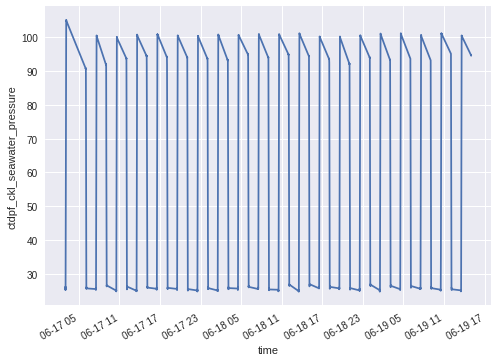

In [14]:
#ds['ctdpf_ckl_seawater_pressure'][0:100000].plot()
ds['ctdpf_ckl_seawater_pressure'][0:20000].plot()



It looks like during this time period the profiler regularly visited the depths of approximately 100, 90, and 25 in repeating order.


As a rough check on the consistency of this depth profile over the entire deployment, let's plot a timeseries of pressure over the whole dataset.  We should expect to see a solid block of blue, representing regular behavior as we saw in the previous plot carried out over the entire deployment.

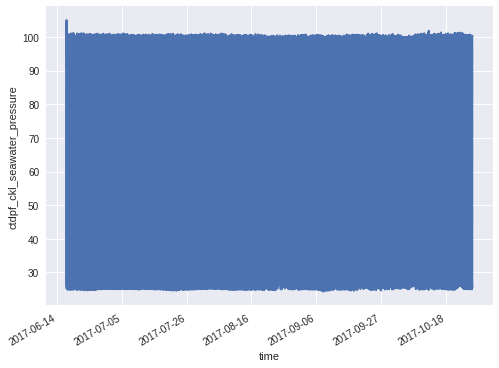

In [15]:
ds['ctdpf_ckl_seawater_pressure'].plot();


It appears as though the profiler did not get stuck at any point during this deployment, and that it consistently traveled between its initial depth endpoints.  Now, let's take a look at the full timeseries of temperature.  

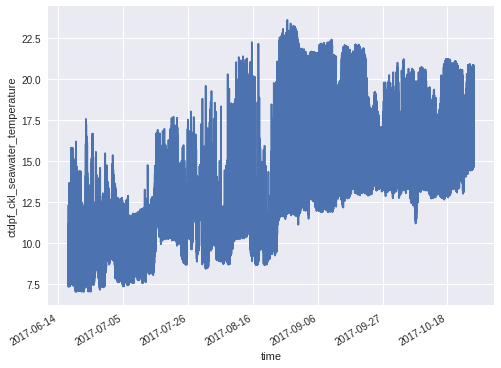

In [16]:
ds['ctdpf_ckl_seawater_temperature'].plot();

This is not the most useful plot, as the full depth range of the profiler is also included, but it does provide a general sense of the data.  The temperature "envelope" has a smaller range in the early summer (between 7.5 and 17.5 degrees), which narrows in July before widening considerably in the early fall.  As fall progresses, the temperature range evolves from spanning 11 and 22.5 degrees to spanning 12.5 and 21 degrees through the end of the deployment in early November.  While sea surface temperature in the region typically peaks in July and August before steadily decreasing into winter, satellite images show regular gulf stream impingement in the area via rings and filaments through early November (2017 images in order: July 7, August 23, September 5, October 4, November 3 2017)

![Sea Surface Temperature for 07/08/2017](https://marine.rutgers.edu/cool/regions/bigbight/sst_comp/noaa/2017/img/170708.189.comp.lnt.jpg =x300)

![Sea Surface Temperature for 08/23/2017](https://marine.rutgers.edu/cool/regions/sw06/sst/noaa/2017/img/170823.235.0012.n18.jpg =x300)

![Sea Surface Temperature for 09/05/2017](https://marine.rutgers.edu/cool/regions/bigbight/sst_comp/noaa/2017/img/170905.248.comp.lnt.jpg =x300)

![Sea Surface Temperature for 10/04/2017](https://marine.rutgers.edu/cool/regions/bigbight/sst_comp/noaa/2017/img/171004.277.comp.lnt.jpg =x300)

![Sea Surface Temperature for 11/3/2017](https://marine.rutgers.edu/cool/regions/bigbight/sst_comp/noaa/2017/img/171103.307.comp.lnt.jpg =x300)


Next, let's create some histograms to see the full range of data.  (Thanks to xarray, this is easy to do in just one line!)  Histograms aren't really ideal for understanding a profiler dataset since all depths are included, but let's see what they looks like anyway.

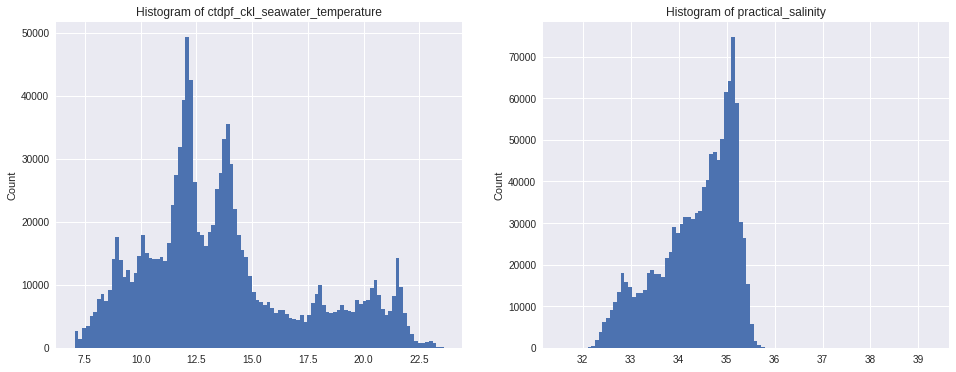

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ds['ctdpf_ckl_seawater_temperature'].plot.hist(bins=100, ax=ax1)
ds['practical_salinity'].plot.hist(bins=100, ax=ax2);


At first glance, the data doesn't appear to include any significant outliers.  However, the salinity histogram appears to have bins for salinity values as high as 39 psu, so we may actually have small numbers of outliers there.  As to whether the times of warm temperature or relatively fresher waters are valid, we'd have to look at the dataset more closely, e.g. specific depths or time periods.

So, let's create a profile timeseries to better understand the full dataset.

In [0]:
dtime = ds['time'].values
pressure = ds['ctdpf_ckl_seawater_pressure'].values
temperature = ds['ctdpf_ckl_seawater_temperature'].values
salinity = ds['practical_salinity'].values


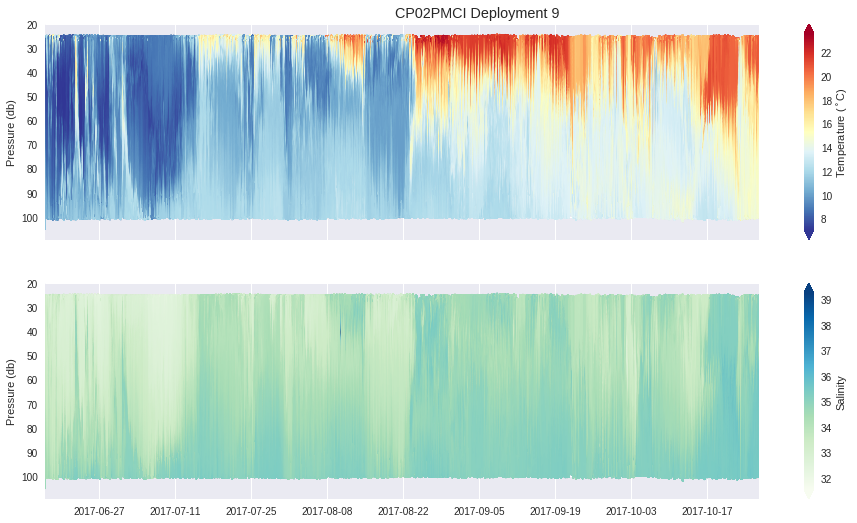

In [19]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,8))
sc1 = ax1.scatter(dtime, pressure, c=temperature, cmap='RdYlBu_r', s=2)
sc2 = ax2.scatter(dtime, pressure, c=salinity, cmap='GnBu', s=2)

# Because the X and Y axes are shared, we only have to set limits once
ax1.invert_yaxis() # Invert y axis
ax1.set_xlim(dtime[0],dtime[-1]) # Set the time limits to match the dataset

cbar = fig.colorbar(sc1, ax=ax1, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
cbar = fig.colorbar(sc2, ax=ax2, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Salinity')

ax1.set_ylabel('Pressure (db)')
ax2.set_ylabel('Pressure (db)')

fig.suptitle('CP02PMCI Deployment 9')
fig.subplots_adjust(top=0.95);


Comparison of temperature and salinity profile timeseries for the entire deployment show that there is a strong correlation between temperature and salinity in the profiles.  Early in the deployment, during summer, low temperature values correspond to low salinity values, suggesting that cool, fresh labrador current water is dominating the water column sampled by the profiler.  The "anomalously" warm temperatures observed in the fall and early winter correspond to peaks in salinity, suggesting the impingement of gulf stream water onto the shelf.  The scale on the salinity plot indicates that there is an anomalous vaue near 39 psu, and we see a small dark patch around August 8, 2017 at around 40db pressure.  This extremely high salinity value was represented in the histogram of the data, and it warrants a deeper investigation that we'll carry out in the next section.

## 5. A closer look
Before looking at the period of crossover between deployments, we should explore the anomolous salinity values observed previously.  In step 4, we used a netCDF file.  For this step, we will grab the data directly from the API using a synchronous request, which is limited to 20K datapoints.


In [0]:
# Setup request for instrument data
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-08-09T00:00:00.000Z',
  'endDT':'2017-08-12T00:00:00.000Z',
  'limit':20000,
}

# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()


In [0]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])

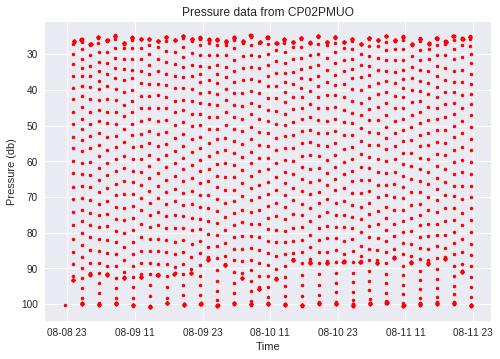

In [51]:
# First, let's make a timeseries of pressure
plt.plot_date(p_time,p_pr,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Pressure (db)')
plt.title('Pressure data from CP02PMUO');

As we thought we observed earlier, the profiler appears to have behaved normally in its climbing pattern during our current period of interest.

(array([312., 635., 535., 525.,   1.,   0.,   1.,   0.,   1.,   1.]),
 array([33.5591232 , 34.04809437, 34.53706555, 35.02603672, 35.5150079 ,
        36.00397907, 36.49295025, 36.98192143, 37.4708926 , 37.95986378,
        38.44883495]),
 <a list of 10 Patch objects>)

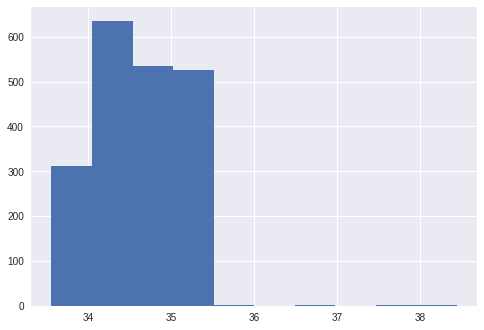

In [52]:
plt.hist(p_sal)



Some experimentation with matplotlib's hist function led to the above histogram, which indicates that there are at least 3 individual data points that fall above a salinity value of 36psu.  Let's see what a scatter plot looks like.

(736550.0, 736553.0)

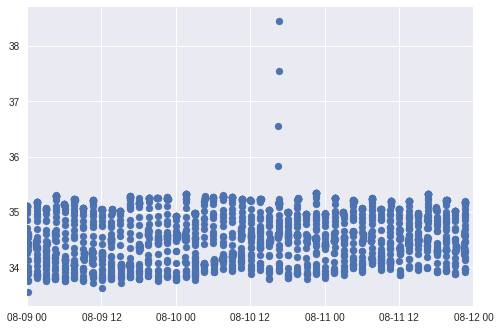

In [62]:
plt.scatter(p_time,p_sal)
plt.xlim(datetime.datetime(2017, 8, 9, 00, 00, 00),datetime.datetime(2017, 8,12, 00, 00, 00))

Playing with matplotlib's "scatter" function led to this scatter plot focusing on the time range containing the anomalous data points, which appears to indicate that all of the outliers were recorded on the same day.   On the x-axis we have time, with 8-10-12 signifying August 10th at 1200 hours.  Let's zoom further in.

(736551.4442013889, 736552.1942013889)

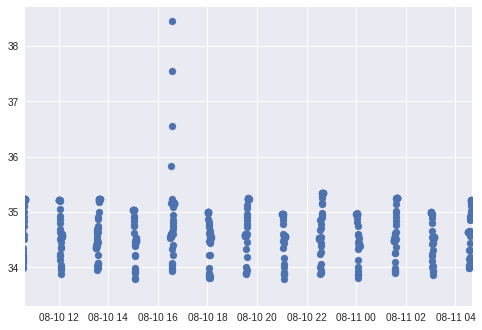

In [59]:
plt.scatter(p_time,p_sal)
plt.xlim(datetime.datetime(2017, 8, 10, 10, 39, 39),datetime.datetime(2017, 8,11, 04, 39, 39))

Let's zoom a bit futher in, focusing on what appear to be individual profiles

(736551.6108680556, 736551.7775347222)

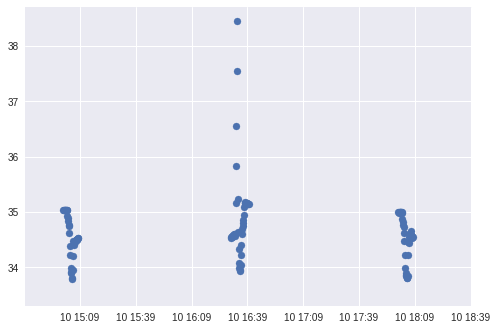

In [60]:
plt.scatter(p_time,p_sal)
plt.xlim(datetime.datetime(2017, 8, 10, 14, 39, 39),datetime.datetime(2017, 8,10, 18, 39, 39))

Ok, one more zoom!

(736551.6868171296, 736551.6951504629)

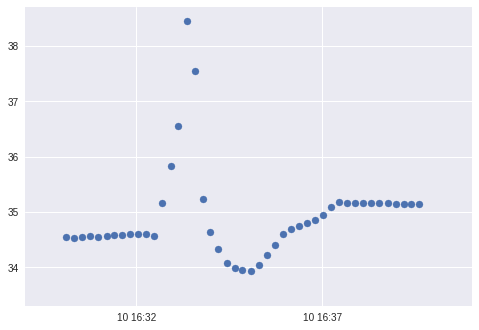

In [68]:
plt.scatter(p_time,p_sal)
plt.xlim(datetime.datetime(2017, 8, 10, 16, 29, 1),datetime.datetime(2017, 8,10, 16, 41, 1))

This looks strange.  Let's compare to the previous profile.

(736551.6236226852, 736551.6319560185)

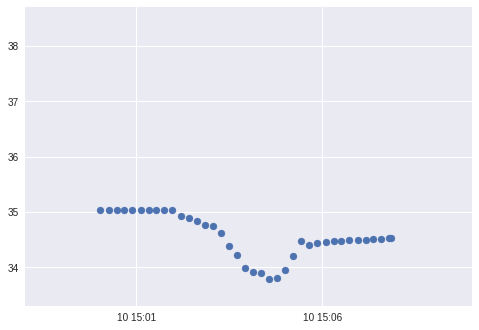

In [72]:
plt.scatter(p_time,p_sal)
plt.xlim(datetime.datetime(2017, 8, 10, 14, 58, 1),datetime.datetime(2017, 8,10, 15, 10, 1))

Comparing these scatter plots of single profiles, it appears as though the ctd recorded six consecutive outlier salinity values in the "anomalous" profile.  Now let's check the depths for the anomalous profile and a "normal" profile. 

(736551.6868171296, 736551.6951504629)

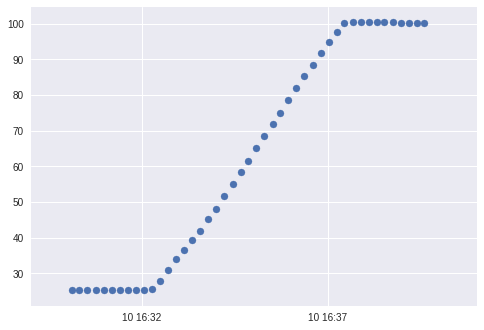

In [73]:
plt.scatter(p_time,p_pr)
plt.xlim(datetime.datetime(2017, 8, 10, 16, 29, 1),datetime.datetime(2017, 8,10, 16, 41, 1))

(736551.6236226852, 736551.6319560185)

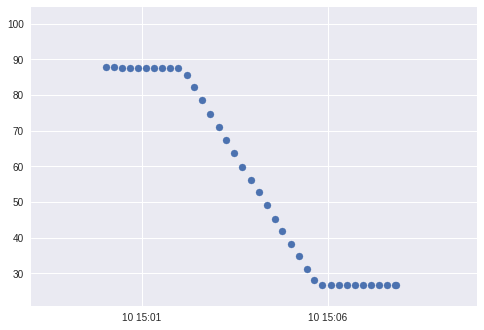

In [74]:
plt.scatter(p_time,p_pr)
plt.xlim(datetime.datetime(2017, 8, 10, 14, 58, 1),datetime.datetime(2017, 8,10, 15, 10, 1))

Both depth profiles look normal.  We also saw from the full data profile plot and the focused scatter plot above that the outlier values were recorded near the surface.  How do the temperature profiles look?  

(736551.6868171296, 736551.6951504629)

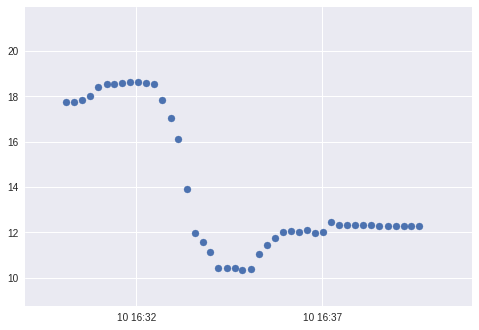

In [75]:
plt.scatter(p_time,p_temp)
plt.xlim(datetime.datetime(2017, 8, 10, 16, 29, 1),datetime.datetime(2017, 8,10, 16, 41, 1))

(736551.6236226852, 736551.6319560185)

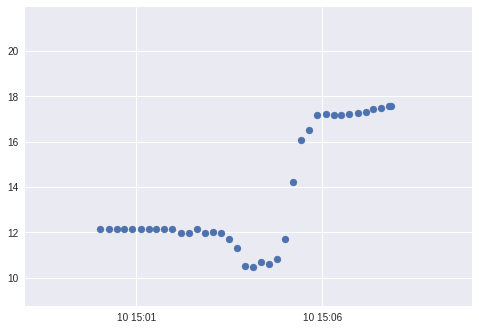

In [76]:
plt.scatter(p_time,p_temp)
plt.xlim(datetime.datetime(2017, 8, 10, 14, 58, 1),datetime.datetime(2017, 8,10, 15, 10, 1))

These mirror each other, indicating consistency in the ctd's temperature measurements.  Now let's look at the previous descending profile, since the anomalous profile was a descending profile.  We'll re-plot the anomalous profile below it for comparison.

(736551.5618171296, 736551.5694560185)

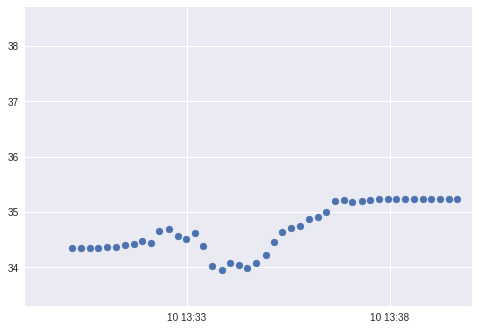

In [88]:
plt.scatter(p_time,p_sal)
plt.xlim(datetime.datetime(2017, 8, 10, 13, 29, 1),datetime.datetime(2017, 8,10, 13, 40, 1))

(736551.6868171296, 736551.6951504629)

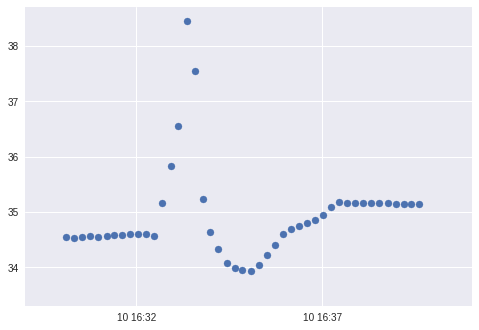

In [86]:
plt.scatter(p_time,p_sal)
plt.xlim(datetime.datetime(2017, 8, 10, 16, 29, 1),datetime.datetime(2017, 8,10, 16, 41, 1))

There is obviously something going during this specific profile.  I would flag this and recommend that the data team contact the engineering team in charge of this deployment and notify them of a potential transient issue with the ctd on CP02PMCI.

Now let's look at one week around the switchover between Deployments 7 and 8.  We'll explore what happens when two deployments overlap in time; in this case, deployment 7 ended on 6/17/2017 and deployment 8 began on 6/16/2017. 

In [0]:
# Setup request for instrument data
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-06-10T00:00:00.000Z',
  'endDT':'2017-06-24T00:00:00.000Z',
  'limit':10000,
}

# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()


In [0]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])


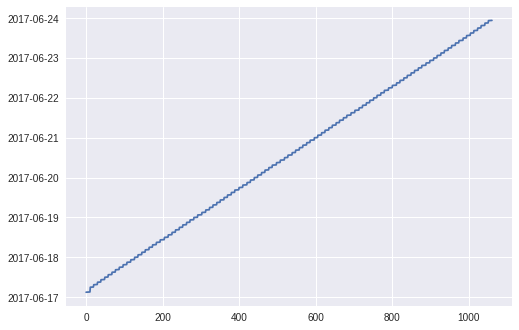

In [108]:
# check if there are overlapping time values
plt.plot(p_time)

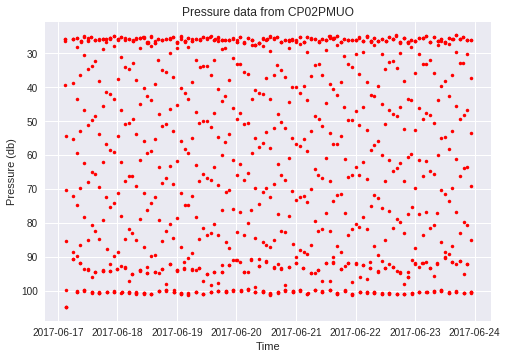

In [103]:
# First, let's make a timeseries of pressure

plt.plot_date(p_time,p_pr,'r.')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Pressure (db)')
plt.title('Pressure data from CP02PMUO');


I struggled for a while but could NOT seem to be able to retrieve data from deployment 7 (which should have included the dates 6/10/2017 - 6/17/2018) in my synchronous request.  Please advise!

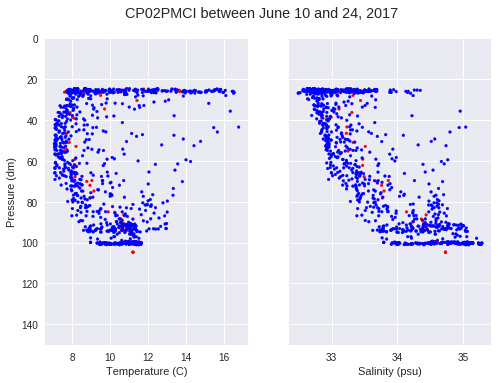

In [100]:
# Profile plots of temperature and salinity
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# Create a color map to divide the two deployments
kcolors = ['red' if t<datetime.datetime(2017,06,17,12,12,00) else 'blue' for t in p_time]
#2017-06-17 12:12:00 

ax1.scatter(p_temp,p_pr, c=kcolors, s=8)
# ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')
# ax1.invert_yaxis()
ax1.set_ylim(150,0)

ax2.scatter(p_sal,p_pr, c=kcolors, s=8)
# ax2.plot(p_sal,p_pr,'r.',label='Pioneer Profiler')
ax2.set_xlabel('Salinity (psu)')
fig.suptitle('CP02PMCI between June 10 and 24, 2017')
fig.subplots_adjust(top=0.9);


I don't trust that the red dots are from deployment 7, since I don't seem to have that data in my pressure profile timeseries.

## 6. Comparison with a shipboard CTD
Finally, we compare the profiler's CTD with data collected during the Pioneer 9 Cruise, Leg 3, Cast #4, which occurred on 2017-11-07 1642 UTC.  Note that, surprisingly to me, there is no telemetered data for deployment 8 past October 18, 2017, so this comparison is more for practice than for rigourous analysis.

The location of the raw ascii data file for the CTD cast can be found below. 

In [0]:
# First, specify the data file for the cruise CTD cast
# Downcast
# cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/ef3f532b-7570-43d9-b016-6b58c4429b15/dar24011.asc'
# Down and Up Casts
#cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/0ddd2680-e35d-46bc-ac1a-d350da4f409d/ar24011.asc'
cruise_data_file = 'https://alfresco.oceanobservatories.org/alfresco/d/d/workspace/SpacesStore/32f88c36-87aa-4dd5-aa36-65ef102c182d/ar18c003.asc'


# Read in the data file without headers due to a bug in the file (two of the header names run together)
cruise_data = pd.read_table(cruise_data_file, delim_whitespace=True, header=None, skiprows=1)

# Add back the necessary headers
cruise_data = cruise_data.rename(columns={0:'Pressure', 1:'Temperature', 13:'Salinity'})


In [0]:
# Next let's grab the Profiler data using a synchronous request 
data_request_url ='/'.join((DATA_API,site,node,instrument,method,stream))

params = {
  'beginDT':'2017-10-17T00:00:00.000Z',
  'endDT':'2017-10-18T00:00:00.000Z',
  'limit':1000,
}

# Grab the data
r = requests.get(data_request_url, params=params, auth=(USERNAME, TOKEN))
data = r.json()
#data


In [0]:
# Process the returned JSON dataset into something we can work with
p_time = []
p_temp = []
p_sal = []
p_pr = []
for i in range(len(data)):
  p_time.append(ntp_seconds_to_datetime(data[i]['time']))
  p_temp.append(data[i]['ctdpf_ckl_seawater_temperature'])
  p_sal.append(data[i]['practical_salinity'])
  p_pr.append(data[i]['ctdpf_ckl_seawater_pressure'])


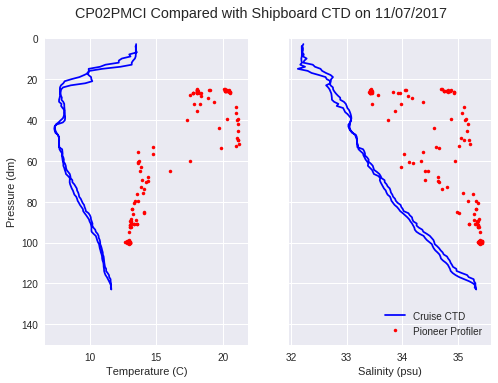

In [126]:
# Now let's plot the Cruise and Profiler data together
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(cruise_data.Temperature,cruise_data.Pressure,'b')
ax1.plot(p_temp,p_pr,'r.')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Pressure (dm)')
# ax1.invert_yaxis()
ax1.set_ylim(150,0)

ax2.plot(cruise_data.Salinity,cruise_data.Pressure,'b',label='Cruise CTD')
ax2.plot(p_sal,p_pr,'r.',label='Pioneer Profiler')
ax2.set_xlabel('Salinity (psu)')

fig.suptitle('CP02PMCI Compared with Shipboard CTD on 11/07/2017')
fig.subplots_adjust(top=0.9)

legend = ax2.legend(loc='lower right', shadow=True, fontsize='small');


As expected, the comparisons between profiler data from October 17 and Cuise CTD casting data from November 7 are not good.  Again, we don't have data from the profiler for the last ~20 days of its deployment, so this was more of an exercise.  I didn't find a more appropriately timed CTD cast for comparison.  

## 7. Notable Results and Actions Needed



Based on this (somewhat cursory) analysis of the Pioneer Central Inshore Profiler (CP02PMCI), we note the following takeaways:
* The profiler CTD recorded a set of consecutive outlier values during a single profile on 8/10/2017
* Telemetered data from deployment 8 stops on 10/17/2017, short of the recorded deployment end date of 11/07/2017.
* In general, besides the anomalous profile noted above, the temperature, salinity and pressure values during deployment 8 look largely reasonable.
* The data seems to align with known physical processes, though additional datasets would need to be consulted to confirm.  This includes:
  * A well defined two-layer system.
  * The surface layer warms and deepens significantly through the summer
  * There are several freshwater surface impulses during the late spring and early fall, which might confirm with rain events
  * The pesistent warm/salty surfaces that persist in the fall may be related to an offshore Gulf Stream filament
  


